# Speed tests for writing to MSSQL from pandas (ODBC)
In this notebook, we'll be playing with various methods of writing data to a Microsoft SQL Server database. Compared to PostgreSQL, which I was using previously, the connection is approximately an order of magnitude slower. This is apparently a known issue. It boggles the mind why, and I might not be searching deep enough to understand the reasons for this, but it's something I can't work around.

Trying to transmit larger volumes of data can also result in errors, as I get memory and connection timeout errors I typically was not having previously.

According to some research, this is due to the ODBC Driver. Whether this is true or not, I do not know. The naive implementation for the `.to_sql()` method from the Pandas docs is:

    df.to_sql(name,
              con,
              schema=None,
              if_exists='fail',
              index=True,
              index_label=None,
              chunksize=None,
              method=None,
             )

## Options
There are various ways known to speed up the process:

1. Use the `method='multi'` parameter for the `to_sql()` method call
2. Add the `execute_fastmany=True` parameter to the SQLAlchemy engine
3. Use both methods 1 and 2
4. Use `sqlalchemy_turbodbc` instead of vanilla SQLAlchemy
5. Use `pymssql` instead of SQLAlchemy

But so far none have been benchmarked for comparison. In this article, we will be juxtaposing these methods to find the best performance in order to write data from a pandas DataFrame to Microsoft SQL Server.

## Failed implementations
I also tried the following methods, but there was some issue or reason behind not including them in the list. This includes:

0. `BULK INSERT`. A workaround we see a lot of in StackOverflow answers is to write your DataFrame to CSV and read it directly with BULK INSERT. I don't have those permissions on this database, so I won't include it. Feels definitely like something that **if you can do, you should try**.
1. `turbodbc` + `fast_executemany`, as this method is not implemented for that SQLAlchemy dialect
2. `pymssql` + `fast_executemany`, as this method is also not implemented for that SQLAlchemy dialect

# Imports

In [1]:
%load_ext nb_black

import json
from os.path import expanduser
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymssql as ms
import sqlalchemy as sql
import sqlalchemy_turbodbc as st

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if sys.path[0] == '':


<IPython.core.display.Javascript object>

We also needed to `pip install sqlalchemy_turbodbc pymssql`, which thankfully get detected when you load them as SQLAlchemy dialects.

# Versions

In [20]:
print("SQLAlchemy version:", sql.__version__)
print("Pandas version", pd.__version__)
print("Numpy version:", np.__version__)
print("pymssql version:", ms.__version__)
try:
    print(st.__version__)
except AttributeError:
    print("No sqlalchemy_turbodbc version available")

SQLAlchemy version: 1.3.5
Pandas version 0.24.2
Numpy version: 1.16.4
pymssql version: 2.1.4
No sqlalchemy_turbodbc version available


<IPython.core.display.Javascript object>

# Environment

In [3]:
HOME = expanduser("~")

# Enterprise DB to be used
DRIVER = "ODBC Driver 17 for SQL Server"
DSN = "tbsuatsql05"
DB = "DS_DEV"
TABLE = "perftest"

conn_sqlalchemy = sql.create_engine(f"mssql+pyodbc://{DSN}/{DB}?driver={DRIVER}")
conn_executemany = sql.create_engine(
    f"mssql+pyodbc://{DSN}/{DB}?driver={DRIVER}", fast_executemany=True
)
conn_turbodbc = sql.create_engine(f"mssql+turbodbc://{DSN}/{DB}?driver={DRIVER}")
conn_pymssql = sql.create_engine(f"mssql+pymssql://{DSN}/{DB}")

<IPython.core.display.Javascript object>

## Create dummy dataset
We'll create somehing here that is sufficiently large to both have a large impact on write times, and that triggers the "too many arguments" error when trying to write with the `'multi'` parameter.

In [4]:
df = pd.DataFrame(np.random.random((10 ** 4, 10)))
print("DataFrame contains", len(df), "rows by", len(df.columns), "columns")
df.head()

DataFrame contains 10000 rows by 10 columns


,0,1,2,3,4,5,6,7,8,9
0,0.607888,0.781212,0.675627,0.911531,0.441672,0.201854,0.466212,0.487489,0.233816,0.997825
1,0.365243,0.662150,0.374518,0.303049,0.718934,0.066836,0.659033,0.958759,0.821536,0.538544
2,0.640548,0.575734,0.856385,0.380706,0.125498,0.733077,0.186904,0.696862,0.452278,0.083290
3,0.466837,0.247153,0.387015,0.382428,0.290844,0.506672,0.551482,0.599074,0.527711,0.305163
4,0.923775,0.127416,0.085155,0.924849,0.925616,0.896660,0.982114,0.851376,0.672755,0.859688


<IPython.core.display.Javascript object>

In [5]:
print("DataFrame is", round(sys.getsizeof(df) / 1024 ** 2, 1), "MB")

DataFrame is 0.8 MB


<IPython.core.display.Javascript object>

# Results

## Option 1 &mdash; Vanilla pandas

In [6]:
%%time
df.to_sql(TABLE, conn_sqlalchemy, index=False, if_exists='replace')

Wall time: 23.5 s


<IPython.core.display.Javascript object>

## Option 2 &mdash; `df.to_sql(..., method='multi')`
This method smashed the chunksize limit for MS SQL, so we have to break up the insert by chunks of 2100 parameters. Pandas has the `chunksize=2100` parameter, but unfortunately in our testing we get database errors I can't troubleshoot only using pandas.

Instead, we'll build a little helper function to do this for us:

In [7]:
def chunker(seq, size):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def insert_with_progress(df, engine, table="", schema=""):
    con = engine.connect()

    # Replace table
    engine.execute(f"DROP TABLE IF EXISTS {schema}.{table};")

    # Insert with progress
    SQL_SERVER_CHUNK_LIMIT = 2099
    chunksize = math.floor(SQL_SERVER_CHUNK_LIMIT / len(df.columns))

    for chunk in chunker(df, chunksize):
        chunk.to_sql(
            name=table,
            con=con,
            if_exists="append",
            index=False,
            schema=schema,
            method="multi",
        )

<IPython.core.display.Javascript object>

In [8]:
%%time
# Doing it like this errors out. Can't seem to be able to debug the straight pandas call.
# df.to_sql(TABLE, conn_sqlalchemy, index=False, if_exists='replace', method='multi', chunksize=2100)

insert_with_progress(df, conn_sqlalchemy, table=TABLE)

Wall time: 3.09 s


<IPython.core.display.Javascript object>

## Option 3 &mdash; `fast_executemany=True`
N.B. This is currently the recommended method in the pandas documentation.

In [9]:
%%time
df.to_sql(TABLE, conn_executemany, index=False, if_exists='replace')

Wall time: 500 ms


<IPython.core.display.Javascript object>

For a 0.8MB table this is still remarkably slow, but we're now ~50 x faster than vanilla!

## Option 4 &mdash; `'multi'` + `fast_executemany`

In [10]:
%%time
insert_with_progress(df, conn_executemany, table=TABLE)

Wall time: 3 s


<IPython.core.display.Javascript object>

Oddly, these two methods to make things faster don't compound well! We get basically the same speed as with `'multi'`

## Option 5 &mdash; sqlalchemy_turbodbc

In [11]:
%%time
df.to_sql(TABLE, conn_turbodbc, index=False, if_exists='replace')

Wall time: 1.17 s


<IPython.core.display.Javascript object>

So, over a 20x speedup from the vanilla settings, but still 2-3x slower than with the `fast_executemany` option.

## Option 6 &mdash; sqlalchemy_turbodbc + `'multi'`
`fast_executemany` is not available as an option when creating the engine, but we can still test with the `method='multi'` parameter.

In [12]:
%%time
insert_with_progress(df, conn_turbodbc, table=TABLE)

Wall time: 10.9 s


<IPython.core.display.Javascript object>

## Option 7 &mdash; pymssql
Another ODBC interface that pops up in the StackOverflow answers, this one doesn't quite seem to be up to snuff. Also doesn't have the `fast_executemany` option.

In [13]:
%%time
df.to_sql(TABLE, conn_pymssql, index=False, if_exists='replace')

Wall time: 31.7 s


<IPython.core.display.Javascript object>

## Option 8 &mdash; pymssql + `'multi'`

In [14]:
%%time
insert_with_progress(df, conn_pymssql, table=TABLE)

Wall time: 6.42 s


<IPython.core.display.Javascript object>

# Analysis

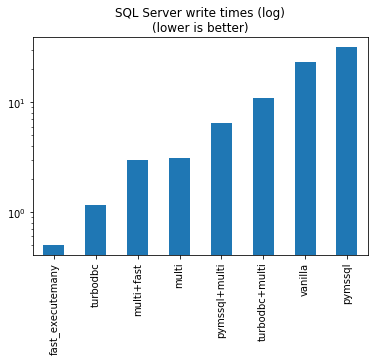

<IPython.core.display.Javascript object>

In [21]:
times = {
    "vanilla": 23.5,
    "multi": 3.09,
    "fast_executemany": 0.5,
    "multi+fast": 3,
    "turbodbc": 1.17,
    "turbodbc+multi": 10.9,
    "pymssql": 31.7,
    "pymssql+multi": 6.42,
}

# We're done with the testing, so remove the testing table
conn_sqlalchemy.execute(f"DROP TABLE IF EXISTS {TABLE};")

# Then plot the results
df_times = pd.DataFrame.from_dict(times, orient="index", columns=["time (s)"])
df_times["time (s)"].sort_values().plot.bar(
    title="SQL Server write times (log)\n(lower is better)", logy=True
)

# Conclusion
So, there we are! In our testing, we've seen that writing to SQL Server through the ODBC connection is substantially slower than e.g. Postgres. There are many ways to make this process faster, but here's the definitive rule of thumb when faced with this situation.

> **Rule of thumb when writing to SQL Server from Pandas**: 
> 
> 1. If you can use `BULK INSERT`, do so
> 2. Else, pass `fast_executemany=True` to your database engine object.
